<a href="https://colab.research.google.com/github/leyuxzhang/NaturalizeNet/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NaturalizeNet(Antinder) Data Preprocessing
This notebook creates a dataset for NaturalizeNet(Antinder) training using the flickr face dataset (https://github.com/NVlabs/ffhq-dataset). For each portrait, we first apply a random number of times of face smoothing, then we add a makeup using a beautyGAN. The result is saved as a collage of the unprocessed and processed portrait.
Thanks https://github.com/Honlan/BeautyGAN and https://github.com/5starkarma/face-smoothing for the models.

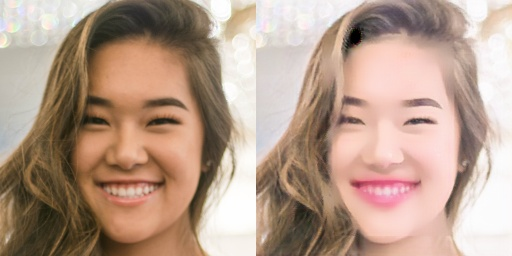
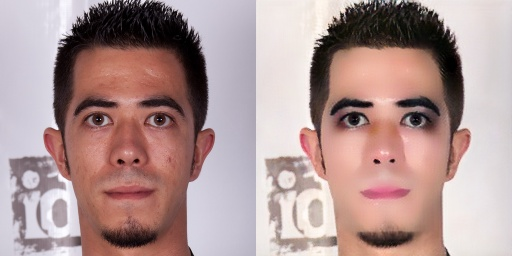

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/face_smoothing')

Import required packages

In [ ]:
import tensorflow as tf
import numpy as np
import os
import glob
from imageio import imread, imsave
import cv2
import argparse
import yaml
import matplotlib.pyplot as plt
from utils.image import (load_image,
                         save_image,
                         save_steps,
                         check_img_size,
                         get_height_and_width,
                         process_image,
                         check_if_adding_bboxes)
from utils.types import (is_image,
                         is_video,
                         is_directory)

# Add make up to the portrait with BeatyGAN
Define the BeautyGAN processing function. We randomly pick one make up style from the "makeup" folder and apply it to the portrait

In [ ]:
def preprocess(img):
    return (img / 255. - 0.5) * 2

def deprocess(img):
    return (img + 1) / 2


def beautyGAN(args, input = None, output_path = None, save_figs = False, mode = "pipeline"):
    batch_size = 1
    img_size = 256
    if input is not None:
        no_makeup = input
        # Convert to RGB, as input from the other pipeline is BGR
        no_makeup = cv2.cvtColor(no_makeup, cv2.COLOR_BGR2RGB)
        h, w, c = no_makeup.shape[0], no_makeup.shape[1], no_makeup.shape[2]
        no_makeup = cv2.resize(no_makeup, (img_size, img_size))
    else:
        no_makeup = imread(args.no_makeup)
        h, w, c = no_makeup.shape[0], no_makeup.shape[1], no_makeup.shape[2]
        no_makeup = cv2.resize(no_makeup, (img_size, img_size))

    if no_makeup.shape[2] == 4:
        no_makeup = no_makeup[: , : , : 3]
    X_img = np.expand_dims(preprocess(no_makeup), 0)
    makeups = glob.glob(os.path.join('/content/drive/MyDrive/makeup', '*.*'))

    if mode == "preview":
        result = np.ones((2 * img_size, (len(makeups) + 1) * img_size, 3))
        result[img_size: 2 *  img_size, :img_size] = no_makeup / 255.

    tf.compat.v1.disable_eager_execution()
    tf.compat.v1.reset_default_graph()
    sess = tf.compat.v1.Session()
    sess.run(tf.compat.v1.global_variables_initializer())
    # Download model from drive and modify the paths here (model to big for git)
    saver = tf.compat.v1.train.import_meta_graph(os.path.join('/content/drive/MyDrive/BeautyGAN_models', 'model.meta'))
    saver.restore(sess, tf.train.latest_checkpoint('/content/drive/MyDrive/BeautyGAN_models'))

    graph = tf.compat.v1.get_default_graph()
    X = graph.get_tensor_by_name('X:0')
    Y = graph.get_tensor_by_name('Y:0')
    Xs = graph.get_tensor_by_name('generator/xs:0')
    if mode == "preview":
        for i in range(len(makeups)):
            makeup = cv2.resize(imread(makeups[i]), (img_size, img_size))
            Y_img = np.expand_dims(preprocess(makeup), 0)
            Xs_ = sess.run(Xs, feed_dict={X: X_img, Y: Y_img})
            Xs_ = deprocess(Xs_)
            result[:img_size, (i + 1) * img_size: (i + 2) * img_size] = makeup / 255.
            result[img_size: 2 * img_size, (i + 1) * img_size: (i + 2) * img_size] = Xs_[0]
    else:
        # mode = "pipeline"
        # Randomly pick a makeup
        i = np.random.randint(0, len(makeups))
        makeup = cv2.resize(imread(makeups[i]), (img_size, img_size))
        Y_img = np.expand_dims(preprocess(makeup), 0)
        Xs_ = sess.run(Xs, feed_dict={X: X_img, Y: Y_img})
        result = deprocess(Xs_)[0]
        #result = cv2.resize(Xs_, (h, w))

    if save_figs:
        imsave(os.path.join(output_path, 'result.jpg'), result)

    # Convert to uint8 and bgr, and return
    result = (result * 255).astype(np.uint8)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    return result


## Create the preprocessing pipeline

Load configurations for face smoothing algorithm

In [ ]:
def load_configs():
    """
    Loads the project configurations.

    Returns
    -------
    configs : dict
        A dictionary containing the configs
    """
    with open('/content/drive/My Drive/face_smoothing'\
               '/configs/configs.yaml', 'r') as file:
        return yaml.load(file, Loader=yaml.FullLoader)
    # with open(r'face_smoothing\configs\configs.yaml', 'r') as file:
    #     return yaml.load(file, Loader=yaml.FullLoader)

Load face smoothing configurations and networks

In [ ]:
# Load project configurations
cfg = load_configs()
# Load the network
net = cv2.dnn.readNetFromTensorflow('/content/drive/MyDrive/face_smoothing/models/opencv_face_detector_uint8.pb',
                                    '/content/drive/MyDrive/face_smoothing/models/opencv_face_detector.pbtxt')


Define input and output paths

In [ ]:
# Input and load image
input_file = '/content/drive/MyDrive/debug_set'
output_path = '/content/drive/MyDrive/antinder_dataset/train'

# Define dataset size
MAX_SIZE = 350

Process and save each portrait. We will apply a the smoothing function 1 to 3 times (randomy chosen), and then add make up with the beautyGAN. Display some processed examples.

Face detected: [34, 39, 182, 209]


<ipython-input-4-261c485ac2db>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  makeup = cv2.resize(imread(makeups[i]), (img_size, img_size))


Face detected: [45, 40, 185, 215]
Face detected: [45, 38, 186, 215]
Face detected: [52, 40, 195, 211]
Face detected: [63, 36, 190, 223]
Face detected: [62, 36, 189, 224]
Face detected: [53, 27, 204, 246]
Face detected: [64, 38, 183, 223]
Face detected: [64, 38, 183, 218]
Face detected: [49, 32, 193, 208]
Face detected: [48, 31, 193, 208]
Face detected: [37, 48, 185, 217]
Face detected: [37, 47, 185, 217]
Face detected: [10, 29, 179, 235]
Face detected: [66, 24, 226, 233]
Face detected: [52, 51, 181, 227]
Face detected: [52, 50, 181, 227]
Face detected: [60, 42, 193, 232]
Face detected: [60, 42, 193, 232]
Face detected: [47, 49, 195, 235]
Face detected: [48, 49, 193, 234]
Face detected: [49, 60, 191, 217]
Face detected: [49, 58, 191, 217]
Face detected: [41, 43, 182, 234]
Face detected: [41, 42, 182, 234]
Face detected: [55, 48, 190, 219]
Face detected: [48, 39, 191, 229]
Face detected: [48, 39, 190, 230]
Face detected: [61, 35, 190, 232]
Face detected: [46, 25, 190, 231]
Face detected:

<ipython-input-11-b5748ae82b7f>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Face detected: [71, 19, 221, 235]
Face detected: [39, 29, 185, 243]
Face detected: [54, 31, 216, 246]
Face detected: [55, 30, 217, 246]
Face detected: [56, 21, 193, 229]
Face detected: [60, 42, 203, 228]
Face detected: [60, 41, 202, 228]
Face detected: [61, 42, 202, 229]
Face detected: [52, 33, 203, 215]
Face detected: [48, 51, 206, 216]
Face detected: [48, 51, 207, 216]
Face detected: [57, 51, 189, 227]
Face detected: [60, 54, 210, 225]
Face detected: [73, 47, 216, 236]
Face detected: [73, 43, 216, 236]
Face detected: [62, 48, 210, 205]
Face detected: [62, 48, 208, 206]
Face detected: [46, 35, 183, 222]
Face detected: [204, 87, 236, 140]
Face detected: [70, 28, 222, 235]
Face detected: [69, 27, 222, 236]
Face detected: [70, 23, 211, 234]
Face detected: [70, 23, 210, 233]
Face detected: [57, 37, 194, 226]
Face detected: [38, 46, 186, 232]
Face detected: [51, 34, 179, 243]
Face detected: [51, 34, 180, 243]
Face detected: [39, 31, 182, 222]
Face detected: [39, 29, 182, 223]
Face detected

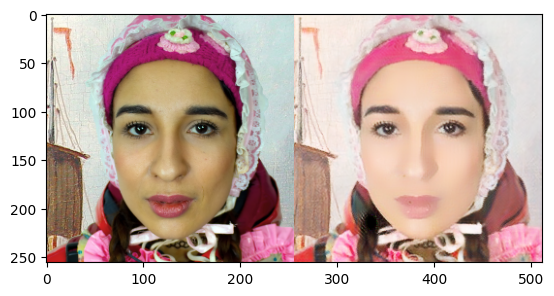

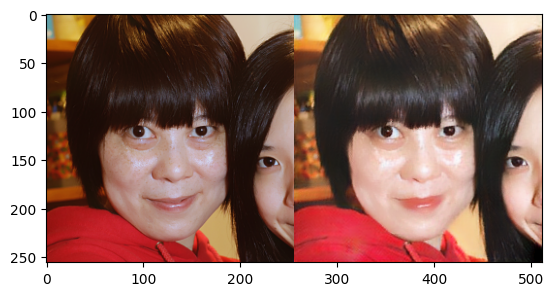

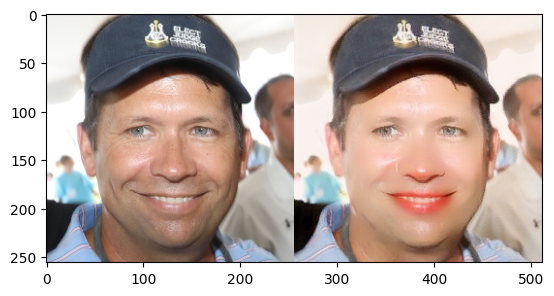

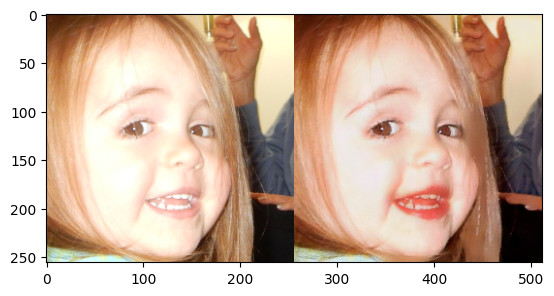

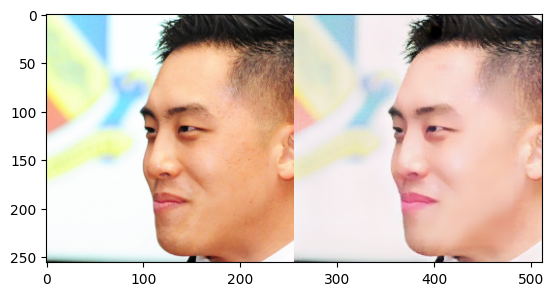

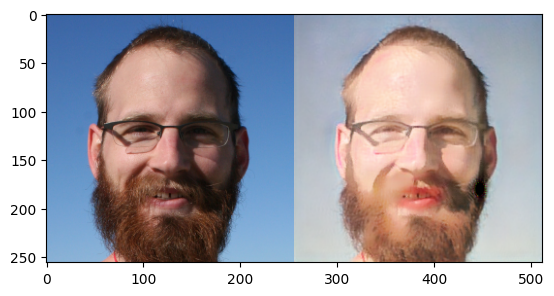

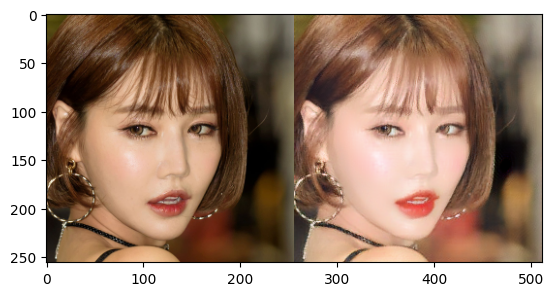

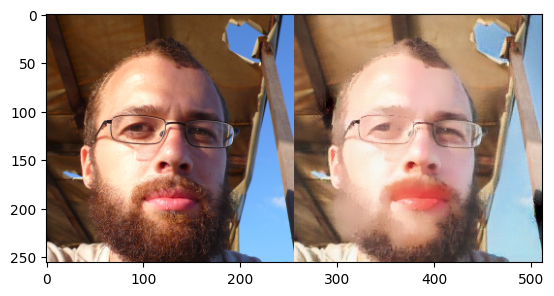

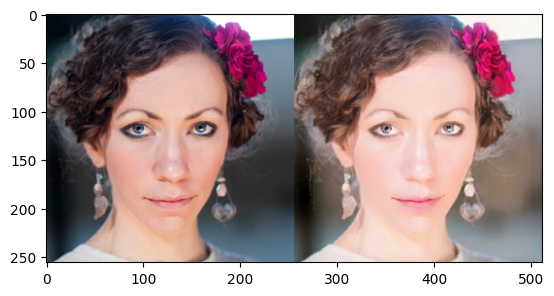

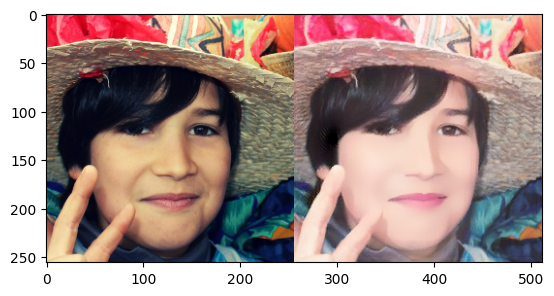

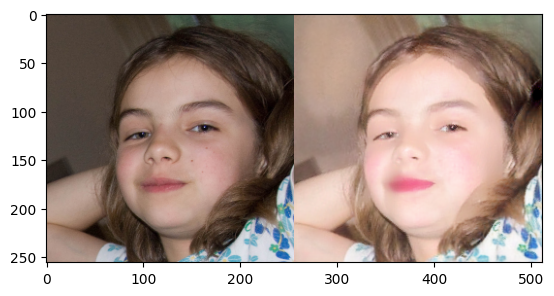

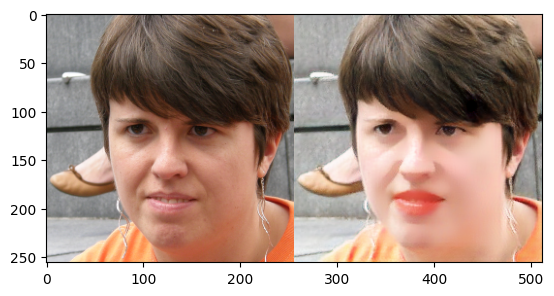

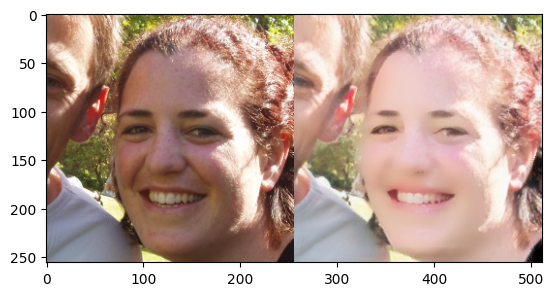

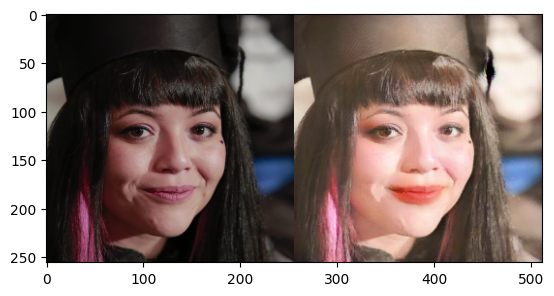

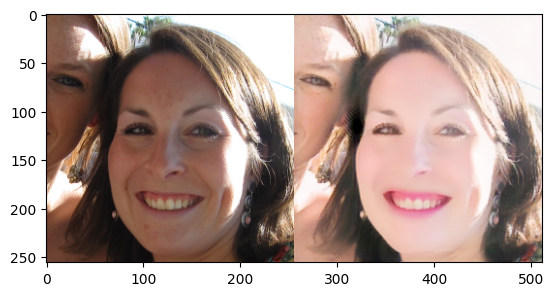

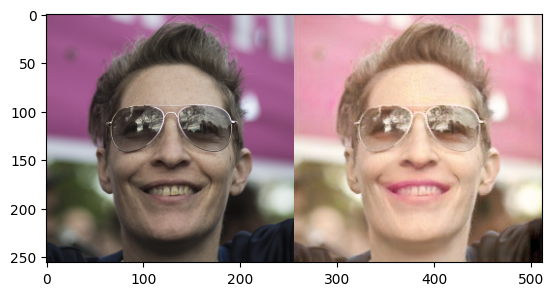

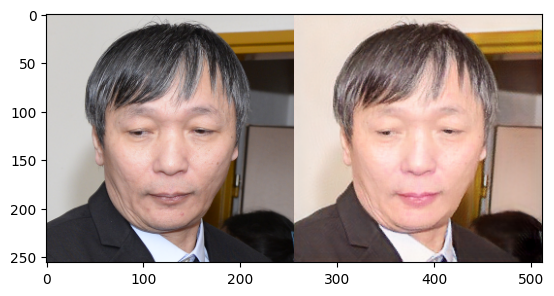

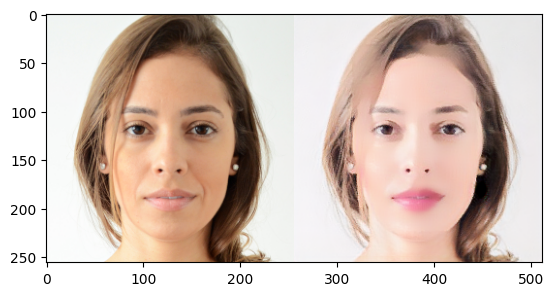

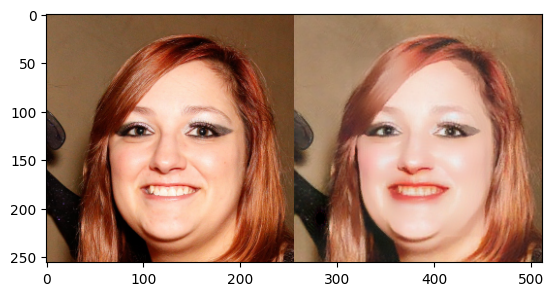

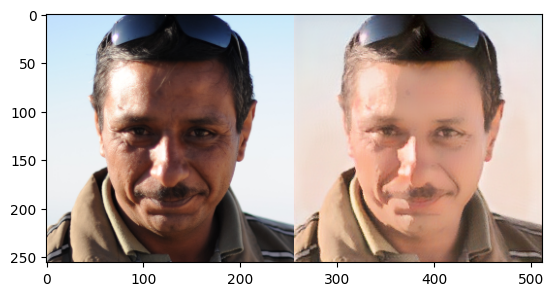

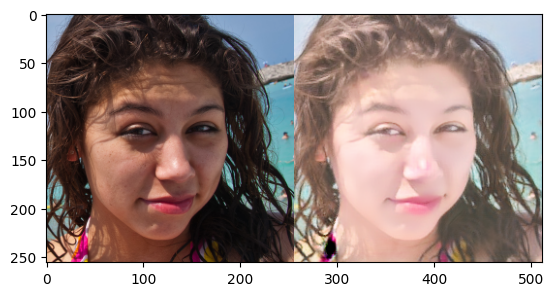

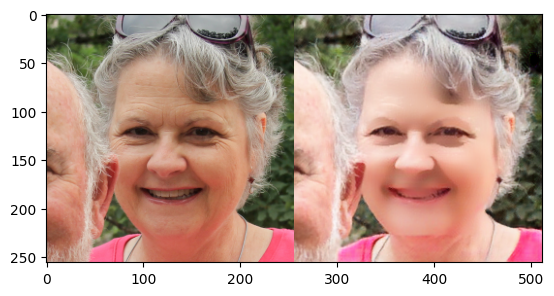

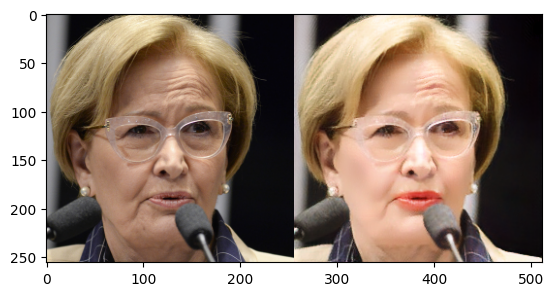

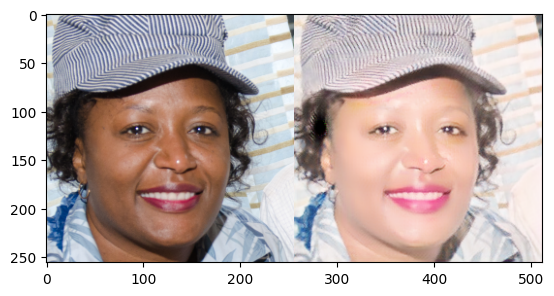

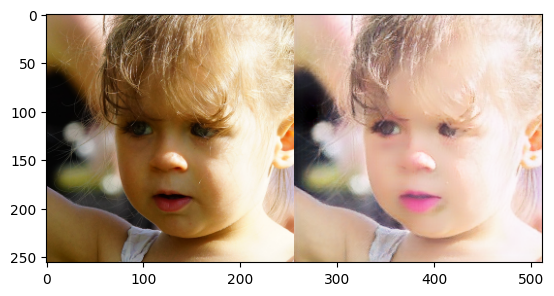

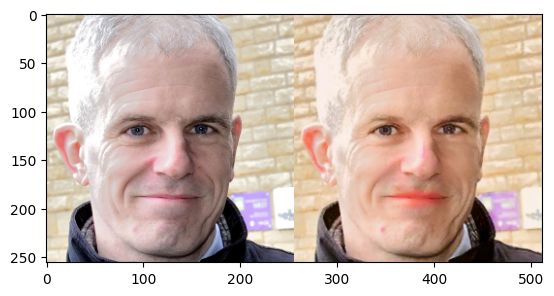

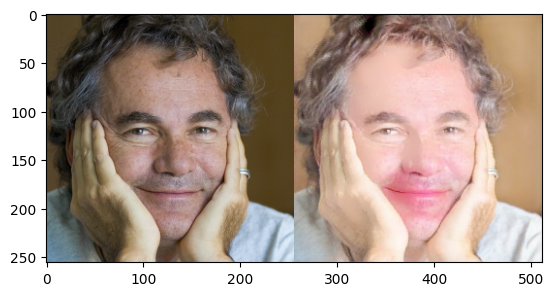

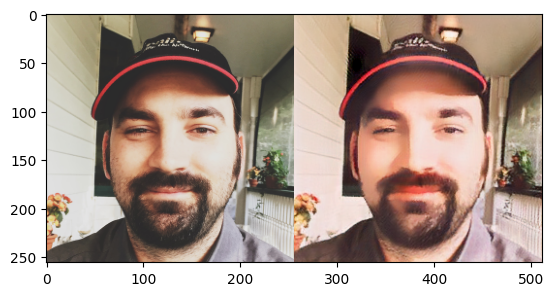

In [ ]:
cnt = 0
for file in os.listdir(input_file):
  files = os.listdir(input_file)
  # Join input dir and file name
  file = os.path.join(input_file, file)
  # Load image
  input_img = load_image(file)
  output_img = input_img
  output = np.ndarray((256, 512, 3))
  # iterate face smoothing 1 or 2 times
  iter = np.random.randint(1, 3)
  for i in range(iter):
    img_steps = process_image(output_img, cfg, net)
    output_img = img_steps[6]
  # Apply beautyGAN to add makeup
  output_img = beautyGAN(args=None, input=output_img)
  # Save image
  out_filename = os.path.join(output_path, cfg['image']['output'])
  output[: , :256, :] = input_img
  output[:, 256:, :] = output_img
  img_saved = save_image(out_filename, output)

  # Pick some images to display
  if np.random.randint(0, 1000) < 100:
    plt.figure()
    example = cv2.cvtColor(output.astype(np.float32), cv2.COLOR_BGR2RGB)
    plt.imshow(example.astype(np.uint16))

  cnt += 1
  if cnt > 350:
    break